# Medical Insurance Cost Prediction
__Goal__: predict cost for medical care of individuals billed by health insurance 
<br>
__Models__: simple linear regression, polynomial regression, random forest regression, SVM, linear SVM regression
<br>
__Data__: Kaggle Medical Insurance Cost Prediction Dataset <br>
Data source: https://www.kaggle.com/datasets/mirichoi0218/insurance
<br>
__Target variable__: charges

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data - dataset from kaggle Medical Insurance Cost Prediction

insurance_df = pd.read_csv('data/insurance.csv')
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# check for missing data

insurance_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
insurance_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
insurance_df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [6]:
insurance_df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
insurance_df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [8]:
insurance_df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [9]:
# transform categorical variables with label encoder

from sklearn.preprocessing import LabelEncoder

labelEnc = LabelEncoder()
labelEnc.fit(insurance_df.sex.drop_duplicates())
insurance_df.sex = labelEnc.transform(insurance_df.sex)

labelEnc.fit(insurance_df.smoker.drop_duplicates())
insurance_df.smoker = labelEnc.transform(insurance_df.smoker)

labelEnc.fit(insurance_df.region.drop_duplicates())
insurance_df.region = labelEnc.transform(insurance_df.region)

In [10]:
# data characteristics 

insurance_df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


In [11]:
# checking correlation of independent to target variable 

insurance_df.corr()['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

## Exploratory Data Analysis

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

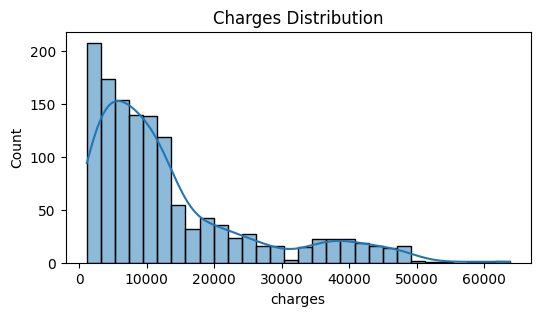

In [12]:
# Data Visualization
# target is charges so checking distribution of charges

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,3))
plt.title('Charges Distribution')
sns.histplot(insurance_df, x = 'charges', kde=True)

plt

Data appears to be positively skewed - so will check for outliers later

<br>The smoker variable is highly correlated with charges(0.8) so I'm interested to see if there is any noticeable trends or patterns

Text(0.5, 1.0, 'Distribution of Charges for Smokers vs. Non-Smokers')

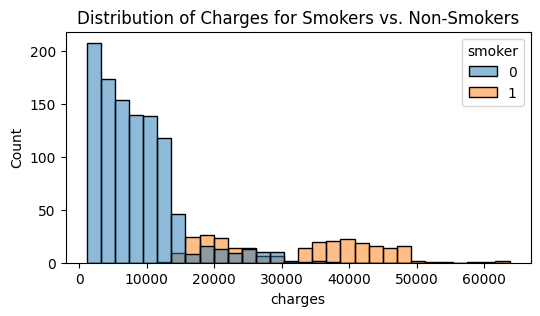

In [13]:
plt.figure(figsize=(6,3))
sns.histplot(insurance_df, x='charges', hue='smoker')
plt.title('Distribution of Charges for Smokers vs. Non-Smokers')

There are only 274 smokers in the dataset, and they are all on the higher end of the charges distribution
<br><br>
Age is the next most highly correlated with charges(0.3), and I am also separating based on smoker status

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

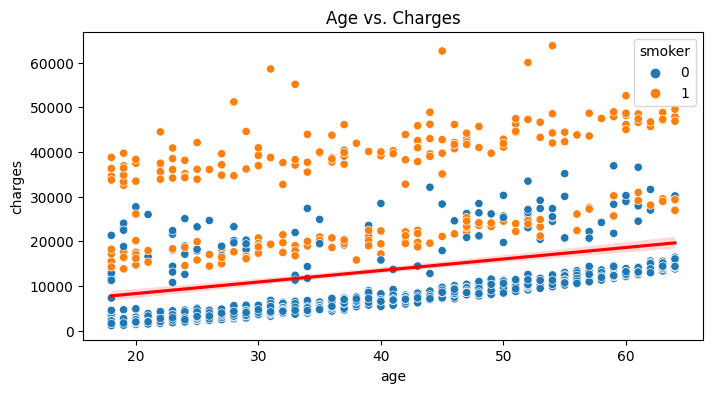

In [14]:
plt.figure(figsize=(8,4))
plt.title('Age vs. Charges')
sns.scatterplot(data=insurance_df, x='age', y='charges', hue='smoker')

# including trend line/regression line 
sns.regplot(data=insurance_df, x='age', y='charges', line_kws={'color': 'red'}, scatter=False)

plt

As age increases, charges increase slightly. The top half of the plot is noticeably full of smokers.  
<br><br>
BMI is the next most correlated at 0.2

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

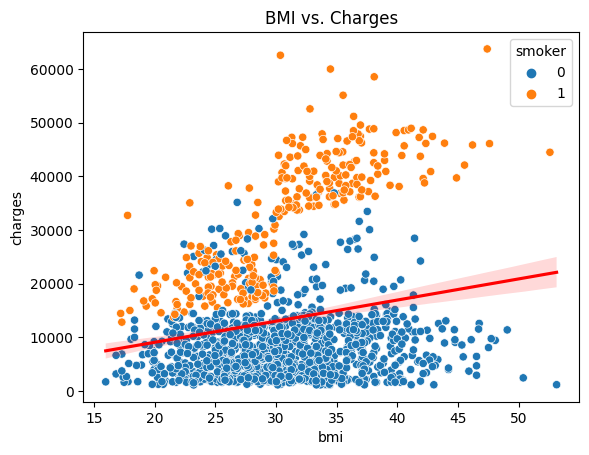

In [15]:
plt.title('BMI vs. Charges')
sns.scatterplot(data=insurance_df, x='bmi', y='charges', hue='smoker')
sns.regplot(data=insurance_df, x='bmi', y='charges', line_kws={'color': 'red'}, scatter=False)

plt

As bmi increases, there is generally a slight increase in charges. Smokers with a bmi greater than 30 have the highest medical costs 

## Data Preparation
Check for outliers, transform values <br>

In [16]:
# charges histogram is not centered, so check for skew
print('Visually: Data skews right (Bulk of the charges are on the lower side)')
print('Kurtosis: ', "%.2f" % insurance_df['charges'].kurtosis())


Visually: Data skews right (Bulk of the charges are on the lower side)
Kurtosis:  1.61


<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

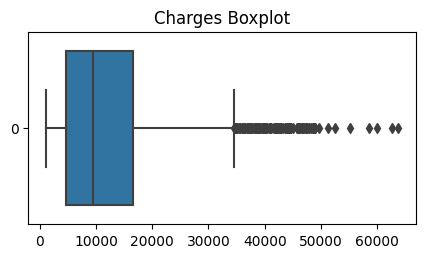

In [17]:
# check for outliers in target variable - box plot of charges 

plt.figure(figsize=(5,2.5))
sns.boxplot(data=insurance_df['charges'], orient="h")
plt.title('Charges Boxplot')
plt

In [18]:
# outliers determination: z-scores of data points 

outliers = insurance_df[insurance_df['charges'] > insurance_df['charges'].mean() + 3 * insurance_df['charges'].std()]
outliers

,age,sex,bmi,children,smoker,region,charges
34,28,1,36.400,1,1,3,51194.55914
543,54,0,47.410,0,1,2,63770.42801
577,31,0,38.095,1,1,0,58571.07448
819,33,0,35.530,0,1,1,55135.40209
1146,60,1,32.800,0,1,3,52590.82939
1230,52,1,34.485,3,1,1,60021.39897
1300,45,1,30.360,0,1,2,62592.87309


__Next step__ - decide if need to remove the outliers from insurance_df

These __outliers__ all have z-scores larger than 3, but they are all reasonable values. All data points have smoker_yes in common so it seems that these data points have relevant information and __will be KEPT in the dataset.__ 

__Charges__: skew found, and will be the first to be transformed<br>
__Independent__: create histograms to determine if any transformations needed

In [19]:
# numpy log is natural log

original_df = insurance_df
insurance_df['charges'] = np.log(insurance_df['charges'])

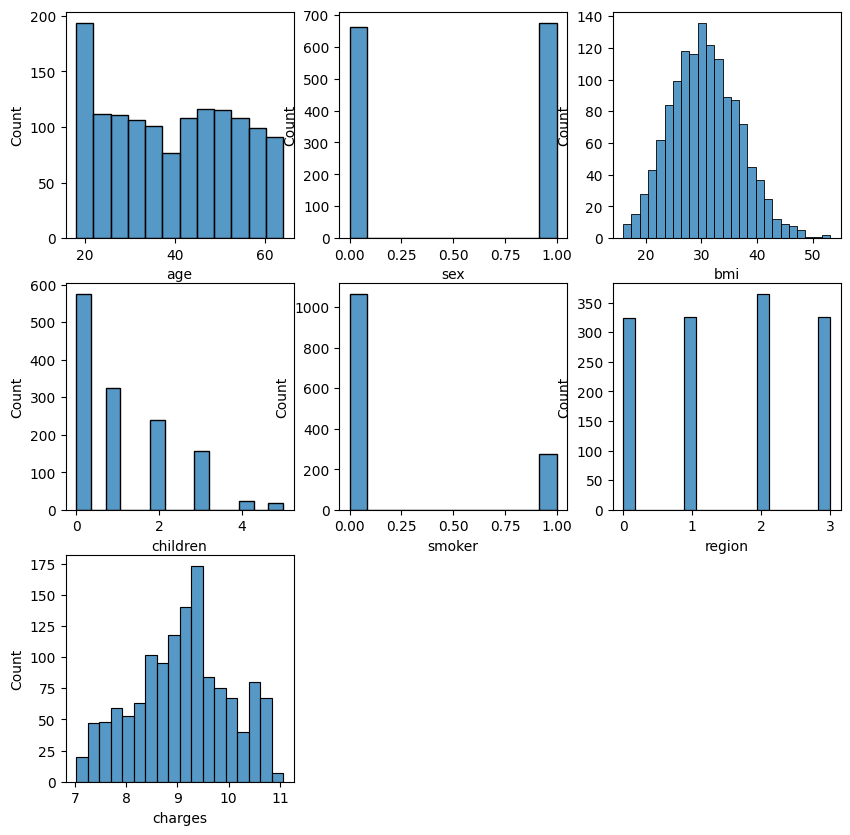

In [20]:
# Checking visually for skew 

plt.figure(figsize=(10,10))
for i, column in enumerate(insurance_df.columns, 1):
    plt.subplot(3,3,i)
    sns.histplot(insurance_df[column])

Target variable successfully transformed, and no other variables are skewed so data transformation is complete <br><br>
### Train-Test Split creation

In [21]:
# Create into train test split
from sklearn.model_selection import train_test_split

y = insurance_df['charges']
X = insurance_df.iloc[:,:-1]

random_state = 31
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)


In [22]:
# sklearn metrics to evaluate models

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# dataframe to hold all models' results
results_df = pd.DataFrame(columns = ['Model', 'R^2','MSE', 'MAE','MAPE'])

## Modeling
The models are created by including all independent variables
### Simple Linear Regression
Using ordinary least squares

In [23]:
# baseline OLS regression model with all independent variables
from sklearn.linear_model import LinearRegression

linearReg = LinearRegression().fit(X_train, y_train)
y_pred = linearReg.predict(X_test)


print("Ordinary Least Squares Regression")
print("R^2: " + str(round(linearReg.score(X_test, y_test),2)))
print("MSE: " + str(round(mean_squared_error(y_test, y_pred),2)))
print("MAE: " + str(round(mean_absolute_error(y_test, y_pred),2)))
print("MAPE: " + str(round(mean_absolute_percentage_error(y_test,y_pred),2)))

results_df = pd.concat([results_df,pd.DataFrame.from_records([{'Model': "OLS Linear Regression", 'R^2': linearReg.score(X_test, y_test),'MSE':mean_squared_error(y_test, y_pred), 'MAE': mean_absolute_error(y_test, y_pred), 'MAPE':mean_absolute_percentage_error(y_test,y_pred) }])])

Ordinary Least Squares Regression
R^2: 0.72
MSE: 0.24
MAE: 0.3
MAPE: 0.03


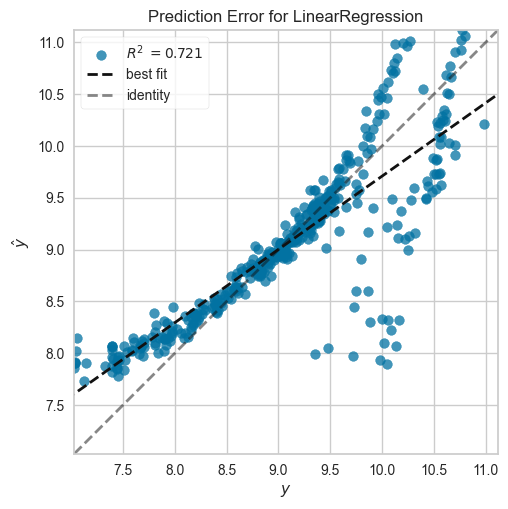

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [24]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(linearReg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

The Prediction Error plot puts the training data on the 45 degree line, the test data's r-squared for the target, and the regression line marked as 'best fit'

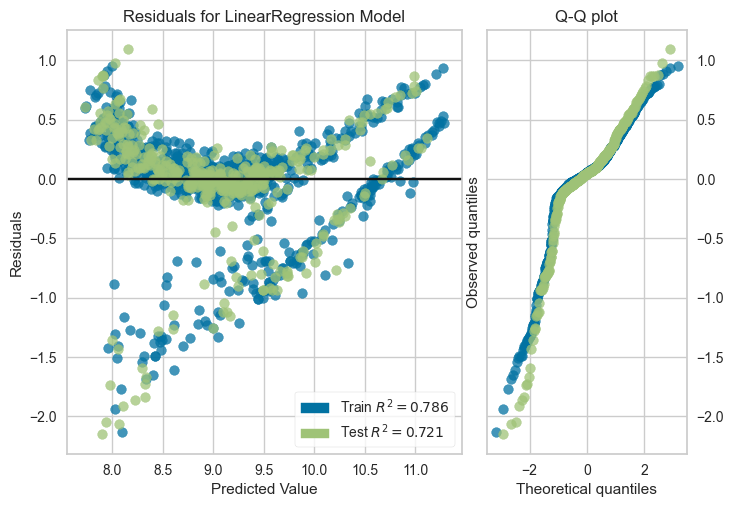

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [25]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(linearReg, hist=False, qqplot=True)
visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test)
visualizer.show()

#### Linear Regression Evaluation

Looking at the prediction error, residual, and qq plots it appears that a linear model is insufficient to explain the relationship between the data <br>

- The prediction error plot shows a section of data points with predictions that are much smaller than the actual values
 - My hypothesis is that these data points might be 'smoker' charges
- The residual plot should have the points dispersed around the 0.0 horizontal axis
- The QQ plot should have the observations approximately on a straight line

### Polynomial Regression
Finding the line of best fit with a higher-order model

In [26]:
# polynomial regression 
from sklearn.preprocessing import PolynomialFeatures

polyFeat = PolynomialFeatures(degree = 2, include_bias = False).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(polyFeat, y, test_size = 0.3, random_state = random_state)
polyRegress = LinearRegression().fit(X_train, y_train)


y_pred = polyRegress.predict(X_test)

print("Polynomial Regression")

print("R^2: " + str(round(polyRegress.score(X_test, y_test),2)))
print("MSE: " + str(round(mean_squared_error(y_test, y_pred),2)))
print("MAE: " + str(round(mean_absolute_error(y_test, y_pred),2)))
print("MAPE: " + str(round(mean_absolute_percentage_error(y_test,y_pred),2)))

results_df = pd.concat([results_df,pd.DataFrame.from_records([{'Model': "Polynomial Regression", 'R^2': polyRegress.score(X_test, y_test),'MSE':mean_squared_error(y_test, y_pred), 'MAE': mean_absolute_error(y_test, y_pred), 'MAPE':mean_absolute_percentage_error(y_test,y_pred) }])])

Polynomial Regression
R^2: 0.79
MSE: 0.17
MAE: 0.22
MAPE: 0.02


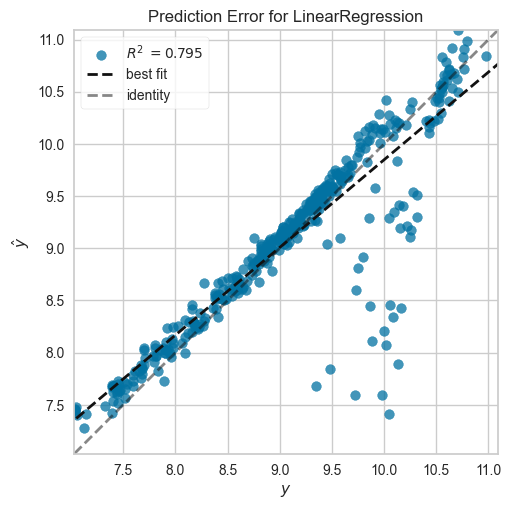

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [27]:
visualizer = PredictionError(polyRegress)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

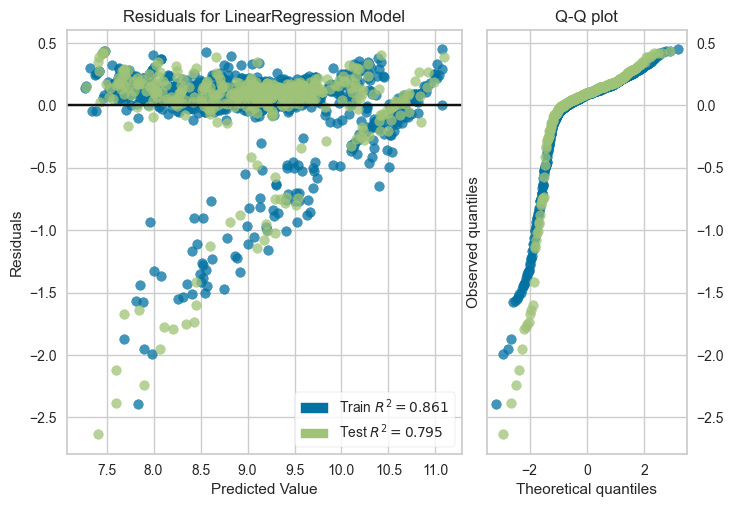

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [28]:
visualizer = ResidualsPlot(polyRegress, hist=False, qqplot=True)
visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test)
visualizer.show()

#### Polynomial Regression Evaluation
This model is much more accurate than the linear model. The points are more closely clustered around the true values line and the residual plot has more normal-appearing residuals around the 0.0 horizontal axis.<br>

There is still a section of very inaccurate predictions and residuals far from the horizontal axis, but it is better than a linear model.<br>

This model is very complex and risks overfitting so it is worth investigating more non-linear models. <br>

In [29]:
# train test split reset 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

### Random Forest Regressor with Cross Validation
This random forest regressor is using grid search to tune the hyperparameters

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'max_depth': [2,3,4,5,6,7],
    'n_estimators': [50,75,100,150,175]
}

randomForest = RandomForestRegressor(random_state=random_state)

grid_search = GridSearchCV(estimator = randomForest, param_grid = param_grid,
                          cv = 3)
grid_search.fit(X_train,y_train)

best_forest = grid_search.best_estimator_

y_pred = best_forest.predict(X_test)

print("Grid Search - Random Forest Regression")
print (grid_search.best_params_)

print("R^2: " + str(round(best_forest.score(X_test, y_test),2)))
print("MSE: " + str(round(mean_squared_error(y_test, y_pred),2)))
print("MAE: " + str(round(mean_absolute_error(y_test, y_pred),2)))
print("MAPE: " + str(round(mean_absolute_percentage_error(y_test,y_pred),2)))

results_df = pd.concat([results_df,pd.DataFrame.from_records([{'Model': "Random Forest Regress.", 'R^2': best_forest.score(X_test, y_test),'MSE':mean_squared_error(y_test, y_pred), 'MAE': mean_absolute_error(y_test, y_pred), 'MAPE':mean_absolute_percentage_error(y_test,y_pred) }])])

Grid Search - Random Forest Regression
{'max_depth': 4, 'n_estimators': 75}
R^2: 0.79
MSE: 0.18
MAE: 0.22
MAPE: 0.02


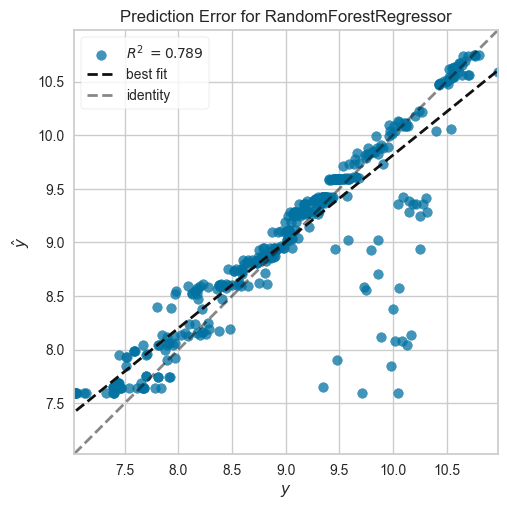

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [31]:
visualizer = PredictionError(best_forest)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

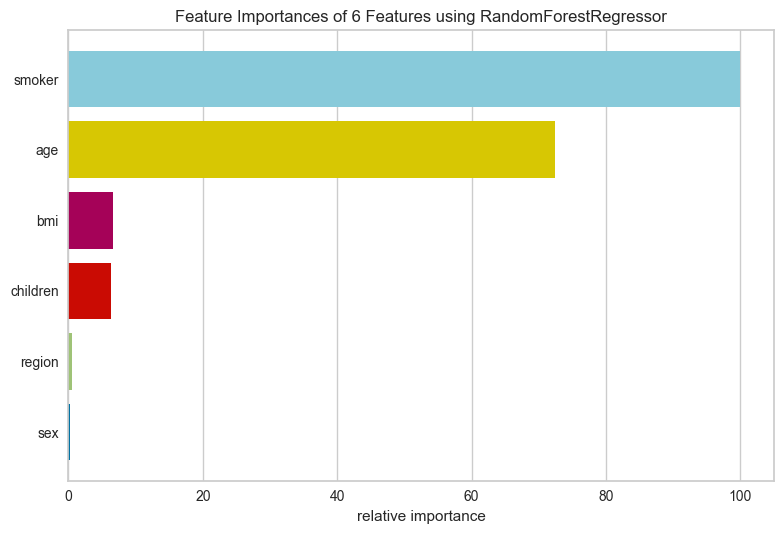

<Axes: title={'center': 'Feature Importances of 6 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [32]:
from yellowbrick.model_selection import FeatureImportances

labels = X.columns
visualizer=FeatureImportances(best_forest,labels=labels)
visualizer.fit(X,y)
visualizer.show()

#### Random Forest Regression Evaluation 
The max depth of the best performing forest is only 4 
<br>
This model performs excellently. Most of the data points are around the 45 degree line. The area of the Prediction Error plot with the large values being underestimated is handled best by the random forest regression. <br><br>
The visualization underneath the error prediction shows the relative importance of the input variables. Smoker is the most important feature and age is also pretty important. 
<br><br>
__Data preprocessing for SVM__

In [33]:
# SVM requires scaled data 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x = insurance_df[['bmi']]
x_scaled = scaler.fit_transform(x)
insurance_df['bmi'] = x_scaled

a = insurance_df[['age']]
a_scaled = scaler.fit_transform(a)
insurance_df['age'] = a_scaled

c = insurance_df[['children']]
c_scaled = scaler.fit_transform(c)
insurance_df['children'] = c_scaled

reg = insurance_df[['region']]
reg_scaled = scaler.fit_transform(reg)
insurance_df['region'] = reg_scaled

insurance_df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,0,-0.453320,-0.908614,1,1.343905,9.734176
1,-1.509965,1,0.509621,-0.078767,0,0.438495,7.453302


In [34]:
# resetting X and y

y = insurance_df['charges']
X = insurance_df.iloc[:,:-1]

random_state = 31
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
X.head(2)

,age,sex,bmi,children,smoker,region
0,-1.438764,0,-0.453320,-0.908614,1,1.343905
1,-1.509965,1,0.509621,-0.078767,0,0.438495


### SVM Regression 

In [35]:
from sklearn.svm import SVR

svmRegress = SVR()

param_grid = {
    'C': [1,3,4,4.5,5,5.5,6,7,8,10],
    'gamma': ['scale','auto'],
    'kernel': ['rbf', 'linear'],
    'epsilon': [0.001,.01,1,10]
}

grid_search = GridSearchCV(estimator = svmRegress, param_grid = param_grid,
                          cv = 3)
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test)


print("Grid Search - SVM  Regression")
print (grid_search.best_params_)

print("R^2: " + str(round(best_svr.score(X_test, y_test), 2)))
print("MSE: " + str(round(mean_squared_error(y_test, y_pred),2)))
print("MAE: " + str(round(mean_absolute_error(y_test, y_pred),2)))
print("MAPE: " + str(round(mean_absolute_percentage_error(y_test,y_pred),2)))

results_df = pd.concat([results_df,pd.DataFrame.from_records([{'Model':"SVM Regression" , 'R^2':best_svr.score(X_test, y_test) ,'MSE':mean_squared_error(y_test, y_pred), 'MAE': mean_absolute_error(y_test, y_pred), 'MAPE':mean_absolute_percentage_error(y_test,y_pred)  }])], ignore_index=True)

Grid Search - SVM  Regression
{'C': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
R^2: 0.78
MSE: 0.19
MAE: 0.14
MAPE: 0.01


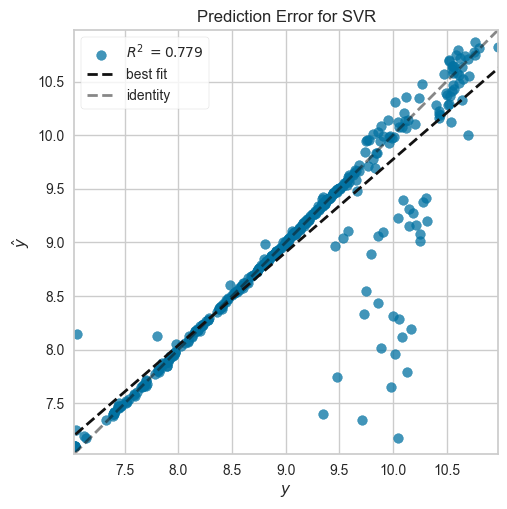

<Axes: title={'center': 'Prediction Error for SVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [36]:
visualizer = PredictionError(best_svr)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

#### SVM Regression Evaluation - (radial kernel)
This model works extremely well. The radial basis function allows precision due to its shape. An r-squared value of 0.78 is very good. This model might be at risk for overfitting. 

<br><br>
SVM with an rbf kernel is unable to rank the features in order of importance, so I am going to use the linear SVR to see what would happen with a linear boundary 
<br><br>
### Linear SVM Regression

In [37]:
from sklearn.svm import LinearSVR

LINEARsvr = LinearSVR(random_state=random_state)

param_grid = {
    'C': [1,10,12.5,13,13.5,15,20,25],
    'tol': [1e-4,1.5e-4],
    'fit_intercept':[False,True],
    'dual':[False,True],
    'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
    'epsilon': [0,0.0001,0.001,0.01,1]
}

grid_search = GridSearchCV(estimator = LINEARsvr, param_grid = param_grid,
                          cv = 3)
grid_search.fit(X_train, y_train)

best_LINEARsvr = grid_search.best_estimator_

y_pred = best_LINEARsvr.predict(X_test)


print("Grid Search - LINEARsvr")
print (grid_search.best_params_)

print("R^2: " + str(round(best_LINEARsvr.score(X_test, y_test), 2)))
print("MSE: " + str(round(mean_squared_error(y_test, y_pred),2)))
print("MAE: " + str(round(mean_absolute_error(y_test, y_pred),2)))
print("MAPE: " + str(round(mean_absolute_percentage_error(y_test,y_pred),2)))
results_df = pd.concat([results_df,pd.DataFrame.from_records([{'Model':"Linear SVM Regression" , 'R^2':best_LINEARsvr.score(X_test, y_test) ,'MSE':mean_squared_error(y_test, y_pred), 'MAE': mean_absolute_error(y_test, y_pred), 'MAPE':mean_absolute_percentage_error(y_test,y_pred)  }])], ignore_index=True)

Grid Search - LINEARsvr
{'C': 13, 'dual': True, 'epsilon': 0, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'tol': 0.0001}
R^2: 0.72
MSE: 0.24
MAE: 0.3
MAPE: 0.03


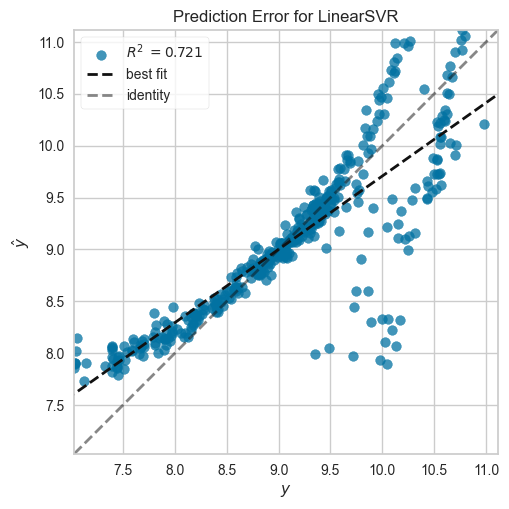

<Axes: title={'center': 'Prediction Error for LinearSVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [38]:
visualizer = PredictionError(best_LINEARsvr)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

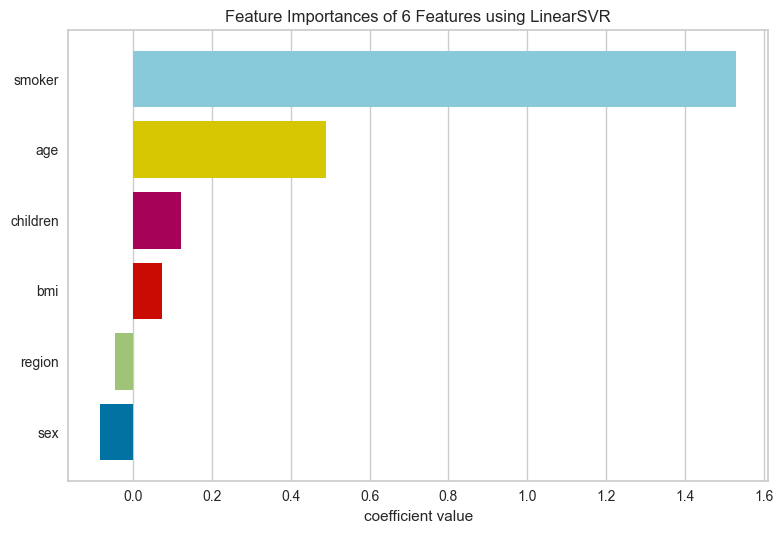

<Axes: title={'center': 'Feature Importances of 6 Features using LinearSVR'}, xlabel='coefficient value'>

In [39]:
labels = X.columns
visualizer=FeatureImportances(best_LINEARsvr,labels=labels, relative=False)
visualizer.fit(X,y)
visualizer.show()

<br>

#### Linear SVM Regression Evaluation

Linear SVM does not fit the data as well as most of the other models. An r-squared value of 0.72 is still pretty good. The Prediction Error plot area with the large data points fits better than the linear models, but still not as well as the radial SVM.

<br>Smoker is the most important feature, with age a distant second

## Model Results

In [40]:
pd.set_option('display.precision', 4)
results_df = results_df.sort_values('R^2', ascending = False)

results_df

,Model,R^2,MSE,MAE,MAPE
1,Polynomial Regression,0.7945,0.1742,0.2157,0.0233
2,Random Forest Regress.,0.7893,0.1786,0.2156,0.0239
3,SVM Regression,0.7788,0.1875,0.1448,0.0148
4,Linear SVM Regression,0.7214,0.2362,0.3018,0.0330
0,OLS Linear Regression,0.7213,0.2362,0.3022,0.0331


## Conclusions
The __top performing models__ are: Polynomial Regression and Random Forest Regression with both model having an r-squared of 0.79 and a MAE of 0.22
<br>

I would move forward with refining: __Random Forest and Linear SVM regression models__
<br><br>
The Random Forest model handles the "dangling" errors in the prediction error plots and has the ability to be pruned to prevent overfitting. <br><br>

The linear SVM model also generalizes pretty well. <br><br>

The polynomial model is very complex and has a blind spot for the "dangling" errors. The SVM regression seems to learn the dataset too well and unlikely to generalize well. However, SVM regression might be worth returning to after more data points are gathered and the independent variables are more finely tuned<br><br>

The issue of __overfitting__ is __not addressed__ in this project.
<br><br>

### Future Considerations
The __next step__ in this project would be to tune the models, especially important is to choose the best performing independent variables. <br><br>

__Variable transformations I'm interested in__:
- Splitting the data based on smokers and non-smokers because the variable is so strongly correlated with charges<br> 
- Creation of a binary "has_children" variable and see how that impacts the model<br>
- Rounding bmi to the nearest whole number or binning bmi into the typical under/overweight/obese categories and see what impact that may have 


### Final Thoughts
As I did not collect this data myself, the 'completeness' of the dataset is unknown to me. Depending on how widespread the data points cover all of the different cases would impact which model is ultimately chosen. 


A possibility worth exploring would be to bin the charges and try prediction again. 


Additionally, doing some unsupervised clustering and seeing if any customer profiles emerge, and if there are trends in the charges would be interesting to explore. 